# Estimation-Maximization (EM) Algorithm

In [64]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Constants

In [167]:
N_GAUSSIANS = 5  # Number of Gaussian distributions.
N_SAMPLES = 1000  # Number of samples.
N_ITERATIONS = 10 # Number of EM iterations.

## 1. Dataset

Define helper functions.

In [66]:
def generateRandomCovarianceMatrix(n):
    """Generate a random covariance matrix.

    To generate a covariance matrix, we need to generate a random matrix Q, then
    Q @ Q.T would be a covariance matrix. This method works because Q @ Q.T has
    non-negative diagnonal elements, and it is symmetric and positive
    semidefinite.

    Args:
        n (int): number of dimensions.

    Return (numpy.ndarray ((n, n) & numpy.float64)): a random covariance matrix.
    """
    
    Q = np.random.default_rng().uniform(low=-1, high=1, size=(n, n))
    return Q @ Q.T

def multinoulli(p):
    """Draw one sample from a multinoulli distribution.

    Args:
        p (numpy.ndarray ((n,))): probability mass funtion.

    Return (int): an integer in [0, n) that represents a category.
    """

    # Retrieve the number of categories.
    n = p.shape[0]

    # Normalize the probabilities so that they sum to 1.
    p_normalized = p / p.sum()

    # Sampling.
    rn = np.random.default_rng().uniform(low=0, high=1)
    cummulated_mass = 0
    for i in range(n - 1):
        cummulated_mass += p_normalized[i]
        if rn < cummulated_mass:
            return i
    return n - 1

Generate the probabilities of selecting each Gaussian distribution.

In [67]:
# We sample in range [0.3, 1) to avoid an extremely small value.
# numpy.ndarray ((N_GAUSSIANS,) & numpy.float64)
p = np.random.default_rng().uniform(low=0.3, high=1, size=N_GAUSSIANS)

# Normalize the probabilities so that they sum to 1.
p /= p.sum()

Generate the means of Gaussian distributions.

In [68]:
# numpy.ndarray ((N_GAUSSIANS, 2) & numpy.float64)
means = np.random.default_rng().uniform(low=-5, high=5, size=(N_GAUSSIANS, 2))

Generate the covariance matrices of Gaussian distributions.

In [69]:
covs = []
for i in range(N_GAUSSIANS):
    covs.append(generateRandomCovarianceMatrix(2))

# numpy.ndarray ((N_GAUSSIANS, 2, 2) & numpy.float64)
covs = np.stack(covs)

Sample data points from Gaussian distributions.

In [70]:
points = []
indices = []

for i in range(N_SAMPLES):

    # Sample the index of Gaussian distributions.
    index = multinoulli(p)
    indices.append(index)

    # Sample a point using a specific Gaussian distribution.
    point = np.random.default_rng().multivariate_normal(mean=means[index], cov=covs[index])
    points.append(point)

# numpy.ndarray ((N_SAMPLES, 2) & numpy.float64)
points = np.stack(points)
# numpy.ndarray ((N_SAMPLES,) & numpy.int32)
indices = np.stack(indices)

Visualize data.

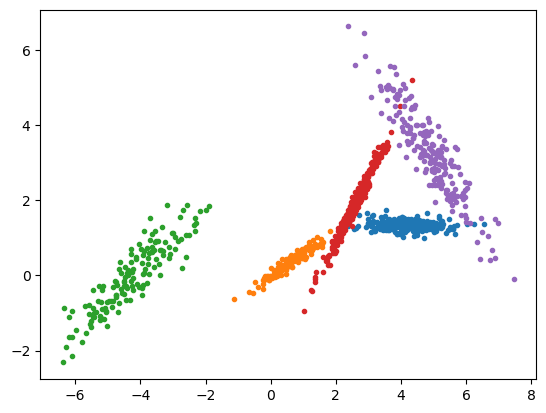

In [71]:
for i in range(N_GAUSSIANS):

    # Get all indices of a single Gaussian distribution.
    indices_single = [] # Indices for a single Gaussian distribution.
    for j in range(N_SAMPLES):
        if indices[j] == i:
            indices_single.append(j)

    plt.plot(points[indices_single,0], points[indices_single,1], '.')

plt.show()

## 2. Inference

Define helper functions.

In [115]:
def pdf(x, mean, cov):
    """Calculate the probability density function for multivariate Gaussian
    distributions.

    Args:
        x (numpy.ndarray ((n, d)))
        mean (numpy.ndarray ((d,))): mean of the Gaussian distribution.
        cov (numpy.ndarray ((d, d))): covariance matrix of the Gaussian
                                      distribution.

    Return (numpy.ndarray ((n,) & numpy.float64)): the probability density.
    """

    # Number of data points.
    n = x.shape[0]

    # Number of dimensions.
    d = x.shape[1]

    # Calculate the exponent.
    exponent = np.empty((n,)) # numpy.ndarray ((n,) & numpy.float64)
    for i in range(n):
        a = x[i][None, :] - mean
        exponent[i] = a @ np.linalg.inv(cov) @ a.T

    # Calculate the probability density.
    return 1 / (np.sqrt(np.power(2 * np.pi, d)) * np.linalg.det(cov)) * \
        np.power(np.e, -0.5 * exponent)

Randomly initialize the parameters.

In [188]:
p_inferred = np.random.default_rng().uniform(size=N_GAUSSIANS)
means_inferred = np.random.default_rng().uniform(size=(N_GAUSSIANS, 2))
covs_inferred = np.random.default_rng().uniform(size=(N_GAUSSIANS, 2, 2))

Infer the parameters iteratively.

In [190]:
for i in range(N_ITERATIONS):

    p_gaussian = []
    for k in range(N_GAUSSIANS):
        p_gaussian.append(pdf(points, means[k], covs[k]))
    # numpy.ndarray ((N_GAUSSIANS, N_SAMPLES) & numpy.float64)
    p_gaussian = np.stack(p_gaussian)

    # numpy.ndarray ((N_GAUSSIANS, N_SAMPLES) & numpy.float64)
    p_gaussian_weighted = p_inferred[None, :].T * p_gaussian

    # numpy.ndarray ((N_SAMPLES,) & numpy.float64)
    p_gaussian_weighted_sum = p_gaussian_weighted.sum(axis=0)

    # numpy.ndarray ((N_GAUSSIANS, N_SAMPLES) & numpy.float64)
    p_z = (p_gaussian_weighted / p_gaussian_weighted_sum)

    # Update the inferred probabilities.
    p_inferred = p_z.mean(axis=1)

    # Update the inferred means.
    points_stacked = []
    for _ in range(N_GAUSSIANS):
        points_stacked.append(points)
    p_z_x = (p_z[:, :, None] * points_stacked).sum(axis=1)
    means_inferred = p_z_x / p_z.sum(axis=1)[:, None]

    # Update the inferred covariance matrices.
    a = np.empty((N_GAUSSIANS, N_SAMPLES, 2, 2))
    for k in range(N_GAUSSIANS):
        for j in range(N_SAMPLES):
            # numpy.ndarray ((2, 2) & numpy.float64)
            b = (points[j] - means_inferred[k])[None, :]
            a[k, j] = b.T @ b
    # numpy.ndarray ((N_GAUSSIANS, N_SAMPLES, 2, 2))
    b = p_z[:, :, None, None] * a
    covs_inferred = b.sum(axis=1) / p_z.sum(axis=1)[:, None, None]

print(f'Original probabilities: {p}')
print(f'Inferred probabilities: {p_inferred}')

print(f'Original means: {means}')
print(f'Inferred means: {means_inferred}')

print(f'Original covariance matrices: {covs}')
print(f'Inferred covariance matrices: {covs_inferred}')

Original probabilities: [0.24571088 0.12439249 0.15856651 0.27879051 0.19253961]
Inferred probabilities: [0.25219886 0.1326622  0.146      0.2819297  0.18720924]
Original means: [[ 4.2660861   1.32871425]
 [ 0.57417881  0.34106302]
 [-4.11739197  0.14306291]
 [ 2.64862133  2.02077954]
 [ 4.8741986   3.30987918]]
Inferred means: [[ 4.24082772  1.34024972]
 [ 0.61608026  0.37168734]
 [-4.24222171 -0.00576331]
 [ 2.62979772  1.98577434]
 [ 4.87812475  3.28978336]]
Original covariance matrices: [[[ 0.5248484  -0.00251834]
  [-0.00251834  0.01383748]]

 [[ 0.28834317  0.17316233]
  [ 0.17316233  0.11725529]]

 [[ 1.16362634  0.90932215]
  [ 0.90932215  0.86284785]]

 [[ 0.25549523  0.43743142]
  [ 0.43743142  0.77071816]]

 [[ 0.70943532 -0.83971937]
  [-0.83971937  1.22765545]]]
Inferred covariance matrices: [[[ 0.56498317 -0.01077829]
  [-0.01077829  0.0140026 ]]

 [[ 0.294743    0.17723598]
  [ 0.17723598  0.11641825]]

 [[ 1.04818654  0.84439982]
  [ 0.84439982  0.83117677]]

 [[ 0.2720

## 3. Verification

This section verifies the correctness of the inferred parameters by sampling new data points.

In [191]:
points_inferred = []
indices_inferred = []

for i in range(N_SAMPLES):

    # Sample the index of Gaussian distributions.
    index = multinoulli(p_inferred)
    indices_inferred.append(index)

    # Sample a point using a specific Gaussian distribution.
    point = np.random.default_rng().multivariate_normal(mean=means_inferred[index], cov=covs_inferred[index])
    points_inferred.append(point)

# numpy.ndarray ((N_SAMPLES, 2) & numpy.float64)
points_inferred = np.stack(points_inferred)
# numpy.ndarray ((N_SAMPLES,) & numpy.int32)
indices_inferred = np.stack(indices_inferred)

Visualize data.

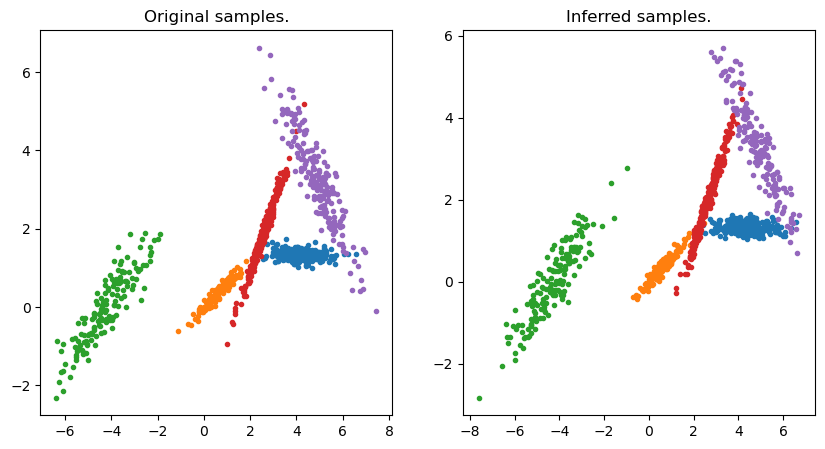

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for i in range(N_GAUSSIANS):

    # Get all indices of a single Gaussian distribution.
    indices_single = [] # Indices for a single Gaussian distribution.
    for j in range(N_SAMPLES):
        if indices[j] == i:
            indices_single.append(j)

    ax1.plot(points[indices_single,0], points[indices_single,1], '.')
    ax1.set_title('Original samples.')

for i in range(N_GAUSSIANS):

    # Get all indices of a single Gaussian distribution.
    indices_single = [] # Indices for a single Gaussian distribution.
    for j in range(N_SAMPLES):
        if indices_inferred[j] == i:
            indices_single.append(j)

    ax2.plot(points_inferred[indices_single,0], points_inferred[indices_single,1], '.')
    ax2.set_title('Inferred samples.')

plt.show()